In [6]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxtyping import Array, Float, Int
from numpyro.handlers import seed, trace
from pydantic import BaseModel

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [2]:
class DataGenerationParameters(BaseModel):
    num_train: int
    num_test: int
    feature_dim: int
    z_gap: float
    y_gap: float


data_generation_parameters = DataGenerationParameters(
    num_train=10_000,
    num_test=2_000,
    feature_dim=10,
    z_gap=1.0,
    y_gap=3.0,
)

In [ ]:
def generate_data(
    num_data: int, feature_dim: int, z_gap: float, y_gap: float
) -> tuple[
    Float[Array, "feature_dim num_data"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
]:
    # Latent confounder z is binary.
    with numpyro.plate("num_data", num_data):
        z = numpyro.sample("z", dist.Bernoulli(0.5))

        # Covariates x are normally distributed, with higher variance for z=1.
        with numpyro.plate("feature_dim", feature_dim):
            x = numpyro.sample("x", dist.Normal(z * z_gap, 5 * z + 3 * (1 - z)))

        # Treatment t is binary, with higher probability for z=1.
        t = numpyro.sample("t", dist.Bernoulli(0.75 * z + 0.25 * (1 - z)))

        # Outcome y is binary, with higher probability for z=1 and t=1.
        y = numpyro.sample("y", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))))

        # Compute true c-specific CATE for evaluation.
        t0_t1 = jnp.array([[0.0], [1.0]])
        y_t0_t1 = numpyro.sample(
            "y_t0_t1", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t0_t1 - 1)))
        )

        y_t0 = y_t0_t1[0]
        y_t1 = y_t0_t1[1]

        true_cates = y_t1 - y_t0

        return (x, t, y, z, true_cates)

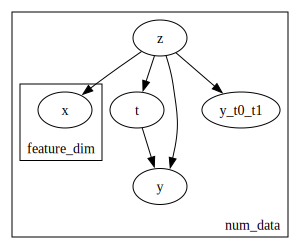

In [4]:
numpyro.render_model(
    generate_data,
    model_kwargs={
        "num_data": data_generation_parameters.num_train,
        "feature_dim": data_generation_parameters.feature_dim,
        "z_gap": data_generation_parameters.z_gap,
        "y_gap": data_generation_parameters.y_gap,
    },
)

In [9]:
x_train: Float[Array, "feature_dim num_train"]
t_train: Int[Array, " num_train"]
y_train: Int[Array, " num_train"]

rng_key, rng_subkey = random.split(rng_key)

x_train, t_train, y_train, _, _ = trace(seed(generate_data, rng_subkey))(
    num_data=data_generation_parameters.num_train,
    feature_dim=data_generation_parameters.feature_dim,
    z_gap=data_generation_parameters.z_gap,
    y_gap=data_generation_parameters.y_gap,
)


x_test: Float[Array, "feature_dim num_test"]
z_test: Int[Array, " num_test"]
true_cates: Float[Array, " num_test"]

x_test, _, _, z_test, true_cates = trace(seed(generate_data, rng_subkey))(
    num_data=data_generation_parameters.num_test,
    feature_dim=data_generation_parameters.feature_dim,
    z_gap=data_generation_parameters.z_gap,
    y_gap=data_generation_parameters.y_gap,
)